# Baseline Model Development

In [1]:
# | echo: false
%load_ext lab_black

Import Python modules

In [2]:
import json
import os
from datetime import datetime
from typing import Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils import check_array, check_random_state
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

## About

### Objective
This step trains a baseline model for predicting visitors' [propensity to make a purchase on a future visit](https://blog.hubspot.com/agency/predictive-analytics-buyhttps://blog.hubspot.com/agency/predictive-analytics-buy) to the merchandise store on the Google Marketplace, using binary classification.

In ML terms, propensity is the likelihood to buy on a return visit and [this comes from the prediction probability](https://www.analyticsvidhya.com/blog/2021/06/streamlit-for-ml-web-applications-customers-propensity-to-purchase/https://www.analyticsvidhya.com/blog/2021/06/streamlit-for-ml-web-applications-customers-propensity-to-purchase/), which is the [probability that a predicted outcome belongs to one of the two known binary classes](https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/4https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/4) (in the current case, the known classes are will or will not purchase on future visit).

### Data
Currently, three data splits with transformed data were created by the previous step

1. train
2. validation
3. test

Predictive models will be developed using the training data split and validated against the validation data split. This will be used to optimize hyperparameters.

Based on validation scores, the best

1. model
2. features

will then be

1. trained using the combined training and validation split
2. evaluated using the test split

This workflow is used for

1. Baseline model development (this step)
   - features are not used
2. Machine Learning (next step)
   - features will be used

### Baseline Model Requirements
In this project, ML is used to predict visitor propensity (probability) so the chosen baseline distribution must produce a [right-skewed](https://www.statology.org/left-skewed-vs-right-skewed/) distribution (histogram) of probabilities. This would indicate that most visitors are predicted to have close to a zero percent probability of making a purchase on a return visit, which is what we saw during EDA in a previous step.

With this in mind, we have the following two requirements of a suitable baseline model for predicting visitors' propensity to make a purchase on a future visit
1. If we use a [binary classification discrimination threshold](https://datascience.stackexchange.com/a/5026/17543) of 0.5, then a right-skewed histogram of probabilities will result in most visitors having a probablity of less than the threshold (0.5) meaning they would be classified as *not likely to make a purchase on a return visit to the merchandise store*. This would lead to a predicted class imbalance, which is what we want since we observed this class imbalance in the training data. However, just having a class imbalance is not enough. We need a strong class imbalance since approximately 5% of visitors were observed to make a purchase on a return visit. So, we need to modify the the skew (shape) of the baseline distribution that is chosen to match this expected class imbalance seen in the training data.
2. Since we require probabilities, we need to choose a distribution that can be produce floating point values in the range of 0.0 to 1.0.

### Baseline Model Choices
A normal distribution histogram would have a peak in the center, which would indicate that most visitors have between a 25% and 75% chance of making a return purchase, with the peak at 50%. This would not give a strongly right-skewed histogram. In turn, this would not give a strong class imbalance. So, a normal distribution is not a suitable distribution for baseline predictions of visitors' propensity to make a return purchase. By comparison, a `beta` distribution's hyperparameters (`a` and `b`) can be chosen to skew the histogram so that most customers have a low probability (propensity) to make a return purchase. This is more realistic for the current use-case and we would want to choose its hyperparameters to give a class balance of close to 95%-5%. For these reasons, an appropriately shaped `beta` (skewed) distribution is a suitable baseline model for the current use-case.

In order to do this, we will generate randomly sampled predicted probablities (propensity scores) from the `beta` distribution ([1](https://byjus.com/maths/probability-distribution/), [2](https://en.wikipedia.org/wiki/Probability_distribution)) that is [strongly right skewed (positive skew)](https://www.cambridgemaths.org/blogs/skewed-usage-skewed-distribution/). In Python, this can be done using

1. `scipy`, under the `scipy.stats` module (see the [*beta distribution*](https://byjus.com/maths/beta-distribution/) documentation for the `scipy` package)
2. `numpy`, through `numpy.random.beta()` ([link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.beta.html))

`sklearn` offers a `DummyClassifier` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)) that is able to randomly make predictions naively. One naive strategy to make predictions is called `stratified`, which generates predictions that are close to the class imbalance observed in the labels (`y`). This is another suitable choice here due to the imbalance obseved during data preparation. Here, the predicted probabilities are either 0s or 1s since this model makes predictions naively and it is only intended for use as a baseline.

### Overall Approach
During baseline model developmen (or validation), the `a` and `b` hyperparameters of the `beta` distribution (baselline model) will be optimized using the validation data. Since this is a baseline model, model training is not required so ML features are not used. Instead, the predicted probabilities (propensities) will be randomly sampled from the `beta` distribution. Hyperparameter optimization is required so that the shape of the distribution is chosen to match the class imbalance seen in the validation data. During baseline model evaluation, the `beta` distribution (baseline model) with the best hyperparameters will be used to make predictions of visitors' probabilities (propensities) of a future purchase in the test data.

For the built-in `sklearn` `DummyClassifier`, the optimal choice of hyperparameter is `stratified`, so no hyperparameter tuning is performed for this baseline model.

### Evaluation Metrics
Due to the class imbalance, evaluation metrics can be difficult to interpret. The precision will generally be very low since there are so few minority class observations in the training data (we assume this is similar to the distribution in the validation and test splits).

Based on this constraint about class imbalance, we will choose the following metrics

1. F0.5-score (places more weight on precision than recall)
   - in the project scope, this was identified to be the primary ML metric
2. Area under the precision recall curve
   - this is ideal for imbalanced data, where the priority is on maximizing the precision and recall of the minority class
3. uplift
   - sort visitors in validation or test data split by predicted probability score
     - the predicted probability score comes from the baseline model (randomly sampled values between 0 and 1 from the beta distribution) or ML model
   - divide visitors into 20 percentiles (or ventiles) based on the sorted probability score
   - calculate uplift as the ratio of the average minority class probability in the top 5% (best performing ventile) to the average minority class probability across all ventiles
   - the interpretation of `uplift` is the factor by which the baseline or ML model is more effective than a random model
     - a random model would draw from a normal distribution, which does not have a histogram of prediction probabilities that is correctly shaped to reflect visitor buying patterns (class balance) that we saw during EDA
     - due to this, all baseline models explored in this step will be better than a random model
   - the model with the best performance will have the highest uplift

### Assumptions

1. The class distribution (or class balance) seen in the training data (explored during EDA) is similar to the distribution in the validation and test data splits.

### Limitations

1. The definition of uplift does not make a comparison of the predicted and true class labels. Instead, it only defines ventiles based on the predicted probability. This is acceptable since uplift is meant to compare a model's predictive power to a random model. However, this also means it is possible to have a non-zero uplift with an inaccurate model. For this reason, the other metric (area under the precision-recall curve and F0.5-score) must also be used to evaluate model performance, in addition to uplift.

### Notation

1. Hard predictions refer to class labels (0, 1 or `True`, `False`). Soft predictions refer to prectited probabilities (floating point values between 0 and 1).
2. To convert soft predictions to hard labels, a fixed discrimination threshold of 0.5 will be used.

## User Inputs

Get relative path to project root directory

In [3]:
# | code-fold: false
PROJ_ROOT_DIR = os.path.join(os.pardir)

Define the different types of features in the transformed data

1. categoricals
2. numericals
3. categorical features not used in this step
4. metadata features (visit ID, visit number, etc.) for each visit
5. `datetime` features not used in this step

In [4]:
# | code-fold: false
categorical_features = [
    "deviceCategory",
    "bounces",
    "channelGrouping",
    "medium",
    "source",
]
numerical_features = [
    "hits",
    "promos_displayed",
    "promos_clicked",
    "product_views",
    "product_clicks",
    "pageviews",
    "time_on_site",
]

categorical_features_unused = ["last_action"]
metadata_features_unused = [
    "fullvisitorid",
    "visitId",
    "visitNumber",
    "visitStartTime",
]
datetime_features_unused = [
    "quarter",
    "month",
    "day_of_month",
    "day_of_week",
    "hour",
    "minute",
    "second",
]

Get path to `data/processed` in which the transformed data splits (training, validation and test) produced by the (preceding) data transformation step were exported

In [5]:
# | code-fold: false
data_dir = os.path.join(PROJ_ROOT_DIR, "data")
processed_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "processed")
models_dir = os.path.join(PROJ_ROOT_DIR, "models")

Define a Python helper function to change probabilities into labels, using a user-specified discrimination threshold

In [6]:
# | code-fold: false
def convert_soft_to_hard_labels(
    y_pred_proba: pd.Series, disc_threshold: float = 0.5
) -> pd.Series:
    """Convert probabilities to labels."""
    y_pred = (y_pred_proba > disc_threshold).astype(int)
    return y_pred

Below is a helper function to calculate the uplift based on ventiles. The approach used is as follows

1. calculate the average predicted probablity (visitor propensity to purchase on future visit) per ventiles
2. extract the average predicted probablity of the top ventile
3. get the average predicted probability across all ventiles
4. take the ratio of 2. and 3. above to get the uplift

In [7]:
# | code-fold: false
def calculate_uplift_score_using_ventiles(
    df: pd.DataFrame, num_quantiles: int = 20
) -> float:
    """Calculate uplift score using ventiles."""
    # 1. get average probability score of minority class for all ventiles
    df_class_1_avg_score_by_ventile = (
        df.query("true == True")
        .groupby(["ventile"], as_index=False)
        .agg({"pred_proba": "mean"})
        .rename(columns={"pred_proba": "avg_score"})
    )

    # 2. get average probability score of minority class for top ventile
    # (numerator of uplift formula)
    df_class_1_avg_score_top_ventile = df_class_1_avg_score_by_ventile.query(
        f"ventile == {num_quantiles-1}"
    )
    if not df_class_1_avg_score_top_ventile.empty:
        avg_score_top_ventile = df_class_1_avg_score_top_ventile["avg_score"].squeeze()
    else:
        avg_score_top_ventile = 0

    # 3. get average probability score of minority class for all ventiles
    # (denominator of uplift formula)
    avg_score_all_ventiles = df.query("true == True")["pred_proba"].mean()

    # 4. use ratio to calculate uplift score
    uplift_score = avg_score_top_ventile / avg_score_all_ventiles
    return uplift_score

A helper function is defined to retrieve the following metrics that were discussed earlier

1. area under precision recall curve
2. uplift score
   - this function generates ventiles and then calls `calculate_uplift_score_using_ventiles()` to calculate this metric

In [8]:
# | code-fold: false
def get_pr_auc(y_true, y_pred_proba, sample_weights) -> float:
    """."""
    precision, recall, _ = skm.precision_recall_curve(
        y_true, y_pred_proba, pos_label=1, sample_weight=sample_weights
    )
    auc_score = skm.auc(recall, precision)
    return auc_score


def get_uplift_score(
    y_true: np.ndarray, y_pred_proba: np.ndarray, num_ventiles: int = 20
) -> float:
    """Assign ventiles to predicted probabilities and get uplift."""
    # create DataFrame with reverse-sorted ventiles
    df = (
        # create DataFrame from true labels and predicted probabilities
        pd.DataFrame(
            zip(*[y_true, y_pred_proba]),
            columns=["true", "pred_proba"],
        )
        # convert soft predictions to hard labels
        .assign(pred=lambda df: (df["pred_proba"] > 0.5).astype(int))
        # assign ventile
        .assign(
            ventile=lambda df: pd.qcut(x=df["pred_proba"], q=num_ventiles, labels=False)
        )
        # sort in descending order of predicted probability
        .sort_values(by=["pred_proba"], ascending=False)
    )
    # calculate uplift score
    uplift_score = calculate_uplift_score_using_ventiles(df, num_ventiles)
    return uplift_score

::: {.callout-note title="Notes"}

1. This calculation of `uplift` requires a `DataFrame` with the ventiles assigned to each visitor, based on the predicted probability (`pred_proba` column). Ventile number should be a column with the name `ventile`. For ventiles, each bin has a width of 5%. Ventiles are assigned using `pandas.cut()` with q=20 ([link](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html)), so the ventile column has values in the range of 0 to 19 where 19 corresponds to the top ventile (visitors who made a purchase on their return visit to the store who are also in the top 5% of predicted probability scores).
:::

A helper function is defined to get the following metrics

1. evaluation metrics relevant to the use-case
   - F0.5-score (places more weight on precision than recall)
     - provided by `sklearn`
   - Area under the precision recall curve
     - using custom helper function above
   - uplift
     - using custom helper function above
2. other evaluation metrics that are provided by `sklearn` (for informational purposes only)
   - accuracy
   - balanced accuracy
   - precision
   - recall
   - F1-score (places equal weight on precision and recall)
   - F2-score (places more weight on recall than precision)
   - brier score

In [9]:
# | code-fold: false
def get_metrics(
    y_true, y_pred, y_pred_proba, average="binary", zero_division="warn"
) -> Dict[str, float]:
    """Calculate sklearn evaluation metrics."""
    sample_weights = None

    # get area under precision-recall curve
    pr_auc_score = get_pr_auc(y_true, y_pred_proba, sample_weights)

    # assemble summary dict to compute metrics
    metrics_dict = dict(
        # accuracy
        accuracy=skm.accuracy_score(y_true, y_pred),
        # balanced accuracy
        balanced_accuracy=skm.balanced_accuracy_score(y_true, y_pred),
        # precision
        precision=skm.precision_score(
            y_true,
            y_pred,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # recall
        recall=skm.recall_score(
            y_true,
            y_pred,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # f1
        f1=skm.f1_score(
            y_true,
            y_pred,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # f-0.5
        f05=skm.fbeta_score(
            y_true,
            y_pred,
            beta=0.5,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # f2
        f2=skm.fbeta_score(
            y_true,
            y_pred,
            beta=2.0,
            average=average,
            sample_weight=sample_weights,
            zero_division=zero_division,
        ),
        # brier score
        brier=skm.brier_score_loss(
            y_true, y_pred, sample_weight=sample_weights, pos_label=1
        ),
        # area under precision-recall curve (calculated above)
        pr_auc=pr_auc_score,
    )
    return metrics_dict

::: {.callout-note title="Notes"}

1. For `average`, the value chosen is binary so that the metric is calculated and returned for the minority class (visitor made purchase on return visit to merchandise store) only.
2. sample weights are not used to calculate the metrics.
:::

Below is a wrapper function that calls the two helper functions defined above in order to calculate

1. various evaluation metrics
2. percent difference beteeen class imbalance in true and predicted data
3. metadata

The four steps in this function are

1. call `get_metrics()` in order to compute metrics
2. call `calculate_uplift_score_using_ventiles()` in order to compute uplift
3. calculate the percent difference between the true and predicted class imbalance
4. get metadata
   - model hyperparameters
     - type of model (baseline or ML)

In [10]:
# | code-fold: false
def calculate_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    y_pred_proba: pd.Series,
    df: pd.DataFrame,
    params: Dict[str, Union[int, float]],
    num_quantiles: int = 20,
    model_type: str = "baseline",
    average: str = "binary",
    zero_division: str = "warn",
) -> Dict[str, float]:
    """Score predicted values against true values."""
    # 1. standard metrics
    scores = get_metrics(
        y_true,
        y_pred,
        y_pred_proba,
        average=average,
        zero_division=zero_division,
    )

    # 2. uplift score
    uplift_score = calculate_uplift_score_using_ventiles(df, num_quantiles)

    # 3. percent difference between true and predicted class imbalance
    scores.update(
        {
            "uplift": uplift_score,
            "true_class_imbalance": y_true.value_counts(normalize=True)
            .to_frame()
            .transpose()
            .assign(class_imbalance=lambda df: df[False] / df[True])["class_imbalance"]
            .squeeze(),
            "pred_class_imbalance": y_pred.value_counts(normalize=True)
            .to_frame()
            .transpose()
            .assign(class_imbalance=lambda df: df[False] / df[True])["class_imbalance"]
            .squeeze(),
        }
    )
    scores.update(
        {
            "pct_chg_class_imbalance": 100
            * (scores["pred_class_imbalance"] - scores["true_class_imbalance"])
            / scores["true_class_imbalance"]
        }
    )

    # 4. metadata
    scores.update({"params": json.dumps(params), "model_type": model_type})
    return scores

Below is a helper function to customize the axes of a `matplotlib` plot

In [11]:
# | code-fold: false
def customize_axis(ax) -> None:
    """Customize matplotlib axis properties."""
    ax.spines["left"].set_edgecolor("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_edgecolor("black")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["top"].set_edgecolor("whitesmoke")
    ax.spines["top"].set_linewidth(1.5)
    ax.spines["right"].set_edgecolor("whitesmoke")
    ax.spines["right"].set_linewidth(1.5)
    ax.grid(which="both", axis="both", color="gainsboro", zorder=3)

## Get Data

Load the transformed data for the training, validation and test data splits

In [12]:
# | code-fold: false
df_train = pd.read_parquet(
    os.path.join(processed_data_dir, "train_processed.parquet.gzip")
)
df_val = pd.read_parquet(os.path.join(processed_data_dir, "val_processed.parquet.gzip"))
df_test = pd.read_parquet(
    os.path.join(processed_data_dir, "test_processed.parquet.gzip")
)
df_test.head()

,fullvisitorid,visitId,visitNumber,visitStartTime,country,quarter,month,day_of_month,day_of_week,hour,...,added_to_cart,made_purchase_on_future_visit,bounces,last_action,source,medium,channelGrouping,browser,os,deviceCategory
0,6667770433164438858,1487630668,1,2017-02-20 14:44:28,United States,1,2,20,2,14,...,0,False,0,0,google,organic,Organic Search,Chrome,Windows,desktop
1,861894924191702840,1486761793,1,2017-02-10 13:23:13,United States,1,2,10,6,13,...,0,False,0,0,google,organic,Organic Search,Chrome,Windows,desktop
2,987663115799971454,1487812839,1,2017-02-22 17:20:39,United States,1,2,22,4,17,...,0,False,0,0,google,organic,Organic Search,Chrome,Macintosh,desktop
3,7090908358039029290,1487412580,1,2017-02-18 02:09:40,United States,1,2,18,7,2,...,0,False,0,0,google,organic,Organic Search,other,Windows,desktop
4,294074179132707998,1487899413,1,2017-02-23 17:23:33,United States,1,2,23,5,17,...,0,False,0,0,google,other,other,Chrome,Macintosh,desktop


Create a new split with the combination of the training and validation data splits

In [13]:
# | code-fold: false
df_train_val = pd.concat(
    [df_train.assign(split="train"), df_val.assign(split="val")], ignore_index=True
)

::: {.callout-note title="Notes"}

1. The `split` column is appended at the end of the training data split and it contains the string `'train'`. This is repeated for the validation split. This is done so we can filter out each of the three splits (train and validation) later.
2. The best hyperparameters will be determined by training a model on the training split and scoring its predictions on the validation split. The best hyperparameters are those for the model with the highest score on the validation split. Using the best hyperparameters, the model is then trained on the combined training and validation split (`df_train_val`) and then evaluated against the test split. For this reason, `df_train_val` has been created here.
:::

Shuffle the data in the

1. combined training and validation
2. test

data splits

In [14]:
# | code-fold: false
df_train_val = df_train_val.sample(frac=1.0, random_state=88)
df_test = df_test.sample(frac=1.0, random_state=88)

Baseline model development will be performed using this combined training and validation split. The best baseline model will be evaluated using the test data split.

## Get Features and Label

Separate features from the target in the train and validation splits

In [15]:
# | code-fold: false
X_train = df_train_val.query("split == 'train'").drop(
    columns=["made_purchase_on_future_visit"]
)[numerical_features]
y_train = df_train_val.query("split == 'train'")[
    "made_purchase_on_future_visit"
].astype(int)

X_val = df_train_val.query("split == 'val'").drop(
    columns=["made_purchase_on_future_visit"]
)[numerical_features]
y_val = df_train_val.query("split == 'val'")["made_purchase_on_future_visit"].astype(
    int
)

Separate features from the target in the combined train-validation split

In [16]:
# | code-fold: false
X_train_val = df_train_val.drop(columns=["made_purchase_on_future_visit"])[
    numerical_features
]
y_train_val = df_train_val["made_purchase_on_future_visit"].astype(int)

Separate features from the target in the test split

In [17]:
# | code-fold: false
X_test = df_test.drop(columns=["made_purchase_on_future_visit"])[numerical_features]
y_test = df_test["made_purchase_on_future_visit"].astype(int)

## ML Pipelines

### Custom Classifier

Define a [`sklearn` custom estimator](https://scikit-learn.org/stable/developers/develop.html#random-numbers) that randomly draws samples from the [`beta` distribution](https://en.wikipedia.org/wiki/Beta_distribution) using the [`beta` method](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.beta.html#numpy.random.Generator.beta) of a [`numpy` random generator](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.Generator).

In [18]:
# | code-fold: false
class BetaDistClassifier(BaseEstimator, ClassifierMixin):
    """Make predictions based on a continuous beta probability distribution."""

    def __init__(
        self,
        threshold: float = 0.5,
        a: float = 2.31,
        b: float = 0.627,
        random_state=None,
    ):
        """
        Initializes BetaDistClassifier.

        Args:
            a: alpha parameter of beta distribution
            b: beta parameter of beta distribution
            threshold: classification discrimination threshold
            random_state: Controls randomness when sampling from beta distribution
        """
        self.random_state = random_state
        self.threshold = threshold
        self.a = a
        self.b = b

    def fit(self, X, y):
        """Fit estimator."""
        # self.n_features_in_ = X.shape[1]
        # self.feature_names_in_ = X.columns.to_numpy()

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.random_state_ = check_random_state(self.random_state)

        # set attribute for scikit-learn
        self.fitted_ = True
        return self

    def predict_proba(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # randomly sample from beta distribution with specified params a and b
        n_samples = X.shape[0]
        y_proba = self.random_state_.beta(a=self.a, b=self.b, size=n_samples)

        # return 2D array for predictions per class (1st column is majority class
        # and second column is minority class)
        y_proba = np.stack([1 - y_proba, y_proba]).T
        return y_proba

    def predict(self, X):
        """Predict class for X."""
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # get class labels from predicted probabilities
        y = (self.predict_proba(X) > self.threshold).astype(int)[:, 1]
        return y

    def get_params(self, deep=True):
        """Get parameters for this estimator."""
        return {
            "a": self.a,
            "b": self.b,
            "threshold": self.threshold,
            "random_state": self.random_state,
        }

    def set_params(self, **parameters):
        """Set the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [19]:
# | code-fold: false
clf_beta = BetaDistClassifier(a=0.25, b=2.371, random_state=88)

### Built-In Dummy Classifier

Define the [`sklearn` built-in `DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) with `stratified` sampling to replicate the class-imbalance observed in the training data

In [20]:
# | code-fold: false
clf_dummy = DummyClassifier(strategy="stratified", random_state=88)

### Handling Missing Values

Missing values are not present in this dataset. See the discussion in the data transformation step for more details.

### Feature Selection

Features are not used in a baseline model.

### Feature Processing

Features are not used in a baseline model. With this in mind, encoding categorical features or scaling numerical features is not required for a baseline model.

### End-to-End ML Pipelines

Define ML pipelines for all baseline models (classifiers) to be compared in this step

In [21]:
# | code-fold: false
pipe_beta = Pipeline(steps=[("clf", clf_beta)])
pipe_dummy = Pipeline(steps=[("clf", clf_dummy)])

## ML Training using Validation Data

### Splitting Data for Validation

Hyper-parameter tuning is performed for the `DummyClassifier` and `BetaDistClassifier` using `GridSearchCV`. This will be done using the validation data without performing cross-validation. This can be performed using the `PredefinedSplit` from `sklearn` ([link](https://stackoverflow.com/a/70155766/4057186)).

This is used below to split the combined training and validation data

In [22]:
# | code-fold: false
split_index = [-1] * len(df_train_val.query("split == 'train'")) + [0] * len(
    df_train_val.query("split == 'val'")
)
pds = PredefinedSplit(test_fold=split_index)

::: {.callout-note title="Notes"}

1. By using this `PredefinedSplit`, we get the following benefits
   - the baseline models are trained on the training data split, which is obtained using the `split == 'train'` filter
   - the class imbalance used in the `strategy='stratified'` comes from this training data split only without retrieving any observations from the validation data
   - we can use native `scikit-learn` modules, such as `GridSearchCV`, with `cv=PredefinedSplit(...)`, to optimize the hyperparameters of the baseline models
     - this means we do not need to write manual `for` loops to iterate over all the hyperparameter combinations to be checked for the baseline models, train (using the training split) and evaluate (using the validation split) each model inside each iteration and then gather the results at the end; instead, we can use `GridSearchCV` with the desired hyperparameter grid and gather the grid search scores at the end
:::

### HyperParameter Tuning

Define the hyperparameter grids to be scored for both baseline models

In [23]:
# | code-fold: false
param_grid_beta = {
    "clf__a": np.linspace(0.2, 0.4, num=8),
    "clf__b": np.linspace(2.2, 2.6, num=8),
}
param_grid_dummy = {"clf__strategy": ["stratified"]}

### Metrics for Model Scoring

Define the following custom metrics to be used during hyperparameter tuning

1. F0.5-score
2. precision
3. brier score
4. uplift, using ventiles
5. area under precision-recall curve

The two metrics that are relevant to this use-case are the F-0.5 score and the uplift score. The primary metric will be the F-0.5 score. The hyperparameters that give the best (highest) score for the primary metric will be chosen as the best hyperparameters.

A dictionary of `sklearn` custom scorers is defined below so we can use these metrics with `GridSearchCV`

In [24]:
# | code-fold: false
scoring = {
    "f05": skm.make_scorer(
        skm.fbeta_score,
        beta=0.5,
        average="binary",
        sample_weight=None,
        zero_division="warn",
    ),
    "precision": skm.make_scorer(
        skm.precision_score,
        average="binary",
        sample_weight=None,
        zero_division="warn",
    ),
    "precision": skm.make_scorer(
        skm.precision_score,
        average="binary",
        sample_weight=None,
        zero_division="warn",
    ),
    "brier": skm.make_scorer(
        skm.brier_score_loss,
        sample_weight=None,
        pos_label=1,
    ),
    "prauc": skm.make_scorer(get_pr_auc, sample_weights=None),
    "uplift": skm.make_scorer(get_uplift_score, num_ventiles=20, needs_proba=True),
}

Define the columns produced by `GridSearchCV` under the `.cv_results_` attribute that are to be kept

1. `clf`
   - name of model (for this step, the modle name will be baseline)
2. `mean_fit_time`
   - training duration
3. `mean_score_time`
   - scoring duration
4. `params`
   - hyperparameters used
5. `mean_test_f05`
   - F0.5-score on the test split
6. `mean_test_precision`
   - precision on the test split
7. `mean_test_prauc`
   - area under the precision-recall curve on the test split
8. `mean_test_brier`
   - Brier score on the test split
9. `mean_test_uplift`
   - uplift on the test split

In [25]:
gs_cols = [
    "clf",
    "mean_fit_time",
    "mean_score_time",
    "params",
    "mean_test_f05",
    "mean_test_precision",
    "mean_test_prauc",
    "mean_test_brier",
    "mean_test_uplift",
]

Perform hyperparameter tuning using `GridSearchCV` for the custom `beta` baseline models

In [26]:
# | code-fold: false
gs = GridSearchCV(
    estimator=pipe_beta,
    cv=pds,
    param_grid=param_grid_beta,
    refit="f05",
    return_train_score=True,
    scoring=scoring,
    n_jobs=None,
)
_ = gs.fit(X_train_val, y_train_val)
df_validation_scores_beta = pd.DataFrame(gs.cv_results_).assign(
    clf=type(pipe_beta.named_steps["clf"]).__name__
)[gs_cols]
with pd.option_context("display.max_columns", None):
    display(df_validation_scores_beta.head(10))

,clf,mean_fit_time,mean_score_time,params,mean_test_f05,mean_test_precision,mean_test_prauc,mean_test_brier,mean_test_uplift
0,BetaDistClassifier,0.010880,0.034319,"{'clf__a': 0.2, 'clf__b': 2.2}",0.026617,0.027894,0.045713,0.073948,6.838147
1,BetaDistClassifier,0.008813,0.030943,"{'clf__a': 0.2, 'clf__b': 2.257142857142857}",0.027956,0.029762,0.046647,0.071823,7.024176
2,BetaDistClassifier,0.008540,0.030084,"{'clf__a': 0.2, 'clf__b': 2.3142857142857145}",0.034833,0.037559,0.052701,0.069887,7.733085
3,BetaDistClassifier,0.008369,0.029315,"{'clf__a': 0.2, 'clf__b': 2.3714285714285714}",0.028710,0.031405,0.046930,0.068754,6.817600
4,BetaDistClassifier,0.008818,0.032537,"{'clf__a': 0.2, 'clf__b': 2.428571428571429}",0.030054,0.033451,0.047953,0.067007,7.884862
5,BetaDistClassifier,0.009425,0.032975,"{'clf__a': 0.2, 'clf__b': 2.4857142857142858}",0.039409,0.044527,0.056185,0.065165,7.229893
6,BetaDistClassifier,0.008515,0.033642,"{'clf__a': 0.2, 'clf__b': 2.5428571428571427}",0.030896,0.035573,0.048475,0.064173,7.274676
7,BetaDistClassifier,0.008695,0.033321,"{'clf__a': 0.2, 'clf__b': 2.6}",0.032040,0.037500,0.049438,0.062946,6.529846
8,BetaDistClassifier,0.009925,0.033463,"{'clf__a': 0.2285714285714286, 'clf__b': 2.2}",0.044928,0.045509,0.064219,0.077820,6.849453
9,BetaDistClassifier,0.010001,0.033034,"{'clf__a': 0.2285714285714286, 'clf__b': 2.257...",0.036169,0.037179,0.055205,0.076073,6.416212


Perform hyperparameter tuning using `GridSearchCV` for the built-in `DummyClassifier` baseline model

In [27]:
# | code-fold: false
gs = GridSearchCV(
    estimator=pipe_dummy,
    cv=pds,
    param_grid=param_grid_dummy,
    refit="f05",
    return_train_score=True,
    scoring={k: v for k, v in scoring.items() if k not in ["uplift"]},
    n_jobs=None,
)
_ = gs.fit(X_train_val, y_train_val)
df_validation_scores_dummy = (
    pd.DataFrame(gs.cv_results_)
    .assign(mean_test_uplift=None)
    .assign(clf=type(pipe_dummy.named_steps["clf"]).__name__)[gs_cols]
    .sort_values(by=["mean_test_f05"], ascending=False, ignore_index=True)
)
with pd.option_context("display.max_columns", None):
    display(df_validation_scores_dummy)

,clf,mean_fit_time,mean_score_time,params,mean_test_f05,mean_test_precision,mean_test_prauc,mean_test_brier,mean_test_uplift
0,DummyClassifier,0.007559,0.011686,{'clf__strategy': 'stratified'},0.0309,0.031034,0.051055,0.080512,None


Combine validation scores for both baseline models

In [28]:
# | code-fold: false
df_validation_scores = (
    pd.concat([df_validation_scores_dummy, df_validation_scores_beta])
    .assign(
        rank=lambda df: df["mean_test_f05"]
        .rank(ascending=False)
        .astype(int)
        .astype(pd.Int8Dtype())
    )
    .sort_values(by=["rank"], ascending=True)
)
df_validation_scores.head(10)

,clf,mean_fit_time,mean_score_time,params,mean_test_f05,mean_test_precision,mean_test_prauc,mean_test_brier,mean_test_uplift,rank
34,BetaDistClassifier,0.008669,0.030887,"{'clf__a': 0.3142857142857143, 'clf__b': 2.314...",0.062536,0.060353,0.086189,0.086698,5.298005,1
57,BetaDistClassifier,0.008666,0.030218,"{'clf__a': 0.4, 'clf__b': 2.257142857142857}",0.058876,0.054296,0.090704,0.103225,4.793266,2
58,BetaDistClassifier,0.008338,0.030452,"{'clf__a': 0.4, 'clf__b': 2.3142857142857145}",0.057165,0.053130,0.086888,0.099967,4.434738,3
19,BetaDistClassifier,0.008352,0.029666,"{'clf__a': 0.2571428571428572, 'clf__b': 2.371...",0.056139,0.057357,0.074454,0.075506,5.901735,4
14,BetaDistClassifier,0.008467,0.032691,"{'clf__a': 0.2285714285714286, 'clf__b': 2.542...",0.054529,0.059701,0.070238,0.067054,7.923363,5
18,BetaDistClassifier,0.008350,0.029694,"{'clf__a': 0.2571428571428572, 'clf__b': 2.314...",0.054135,0.054461,0.073545,0.078292,6.089055,6
56,BetaDistClassifier,0.009725,0.034417,"{'clf__a': 0.4, 'clf__b': 2.2}",0.052780,0.048263,0.085532,0.108278,4.414328,7
23,BetaDistClassifier,0.008387,0.029809,"{'clf__a': 0.2571428571428572, 'clf__b': 2.6}",0.052423,0.056061,0.068956,0.069651,6.181383,8
30,BetaDistClassifier,0.008796,0.030543,"{'clf__a': 0.2857142857142857, 'clf__b': 2.542...",0.052122,0.053503,0.070372,0.075081,5.883619,9
48,BetaDistClassifier,0.008621,0.031746,"{'clf__a': 0.37142857142857144, 'clf__b': 2.2}",0.051341,0.047551,0.080866,0.102186,4.436388,10


::: {.callout-note title="Notes"}

1. The scores on the training split are returned by `GridSearchCV` and they would appear as column names with the prefix `mean_train_`. These training scores are not used to choose the best hyperparameter. Only the scores on the validation split are used for making this choice.
:::

::: {.callout-tip title="Observations"}

1. The combination that best matches the observed class balance in the validation split does not have the highest `uplift` score.
:::

### Extracting Best Baseline Model

Get the best hyperparameters and evaluation scores for both baseline models

In [29]:
# | code-fold: false
df_validation_scores_best = (
    df_validation_scores.groupby("clf", as_index=False)
    .first()
    .sort_values(by=["mean_test_f05"], ascending=False, ignore_index=True)
)
df_validation_scores_best

,clf,mean_fit_time,mean_score_time,params,mean_test_f05,mean_test_precision,mean_test_prauc,mean_test_brier,mean_test_uplift,rank
0,BetaDistClassifier,0.008669,0.030887,"{'clf__a': 0.3142857142857143, 'clf__b': 2.314...",0.062536,0.060353,0.086189,0.086698,5.298005,1
1,DummyClassifier,0.007559,0.011686,{'clf__strategy': 'stratified'},0.030900,0.031034,0.051055,0.080512,None,57


Finally, we'll extract the hyperparameters of the best baseline model

In [30]:
# | code-fold: false
best_hyperparameters_baseline = df_validation_scores_best.query("rank == 1")[
    "params"
].squeeze()
best_hyperparameters_baseline = {
    k.replace("clf__", ""): v for k, v in best_hyperparameters_baseline.items()
}
best_hyperparameters_baseline

{'a': 0.3142857142857143, 'b': 2.3142857142857145}

## ML Evaluation

The baseline model with the best hyperparameters is now used to make predictions on the test split and on the combined train and validation split.

### Make Predictions

We'll define a new pipeline with the best `beta` baseline model found from above and use the best hyperparameters

In [31]:
# | code-fold: false
pipe = Pipeline(
    steps=[
        ("clf", BetaDistClassifier(random_state=88, **best_hyperparameters_baseline))
    ]
)

We'll train the best baseline model using the combined training and validation data split

In [32]:
_ = pipe.fit(X_train_val, y_train_val)

We'll now make predictions on the

1. combined training and validation split
2. test split

In [33]:
# | code-fold: false
# combined training and validation
y_train_val_pred_proba = pd.Series(
    pipe.predict_proba(X_train_val)[:, 1:].flatten(), index=X_train_val.index
)
y_train_val_pred = convert_soft_to_hard_labels(y_train_val_pred_proba, 0.5)

# test
y_test_pred_proba = pd.Series(
    pipe.predict_proba(X_test)[:, 1:].flatten(), index=X_test.index
)
y_test_pred = convert_soft_to_hard_labels(y_test_pred_proba, 0.5)

### Get True and Predicted Class Imbalance

Next, calculate the true and predicted class imbalance for all observations (visitors) in the

1. combined train and validation data split
2. test data split

A helper function is defined to calculate the percent change in class imbalance

In [34]:
# | code-fold: false
def get_class_imbalance(y_true: pd.Series, y_pred: pd.Series) -> float:
    """Get percent difference between true and predicted labels."""
    true_class_imbalance = y_true.value_counts(normalize=True)
    pred_class_imbalance = y_pred.value_counts(normalize=True)

    true_class_ratio = true_class_imbalance[0] / true_class_imbalance[1]
    pred_class_ratio = pred_class_imbalance[0] / pred_class_imbalance[1]

    pct_chng_class_imbalance = (
        100 * (pred_class_ratio - true_class_ratio) / true_class_ratio
    )
    return [pct_chng_class_imbalance, true_class_ratio, pred_class_ratio]

Calculate true and predicted class imbalance for both splits

In [35]:
# | code-fold: false
(
    pct_chng_class_imbalance_train_val,
    true_class_ratio_train_val,
    pred_class_ratio_train_val,
) = get_class_imbalance(y_train_val, y_train_val_pred)
(
    pct_chng_class_imbalance_test,
    true_class_ratio_test,
    pred_class_ratio_test,
) = get_class_imbalance(y_test, y_test_pred)

### Score Predictions

Finally, evaluate the predictions on both splits by scoring them using all the metrics described earlier

In [36]:
# | code-fold: false
def get_eval_scores(
    y_true: pd.Series,
    y_pred: pd.Series,
    y_pred_proba: pd.Series,
    true_class_ratio: float,
    pred_class_ratio: float,
    pct_chng_class_imbalance: float,
    model_type: str = "baseline",
    split: str = "test",
) -> pd.DataFrame:
    """Get evaluation scores and metadata for predictions."""
    evaluation_scores = get_metrics(y_true, y_pred, y_pred_proba)
    evaluation_scores.update({"uplift": get_uplift_score(y_true, y_pred_proba, 20)})
    df_evaluation_scores = (
        # metrics
        pd.DataFrame.from_dict(evaluation_scores, orient="index")
        .transpose()
        # model type
        .assign(model_type=model_type)
        # best hyperparameters
        .assign(params=json.dumps(best_hyperparameters_baseline))
        # true class imbalance in test data split
        .assign(true_class_imbalance=true_class_ratio)
        # predicted class imbalance in test data split
        .assign(pred_class_imbalance=pred_class_ratio)
        # percent change between true and predicted class imbalance in test data split
        .assign(pct_chg_class_imbalance=pct_chng_class_imbalance)
        .transpose()
        .reset_index()
        .rename(columns={"index": "name", 0: f"value_{split}"})
        .assign(
            col_type=lambda df: pd.Series(
                ["metric"] * len(evaluation_scores) + ["metadata"] * 5
            )
        )
    )
    return df_evaluation_scores

Scoring is performed for the test split and then for the combined train and validation split

In [37]:
# | code-fold: false
# test split
df_evaluation_scores_test = get_eval_scores(
    y_test,
    y_test_pred,
    y_test_pred_proba,
    true_class_ratio_test,
    pred_class_ratio_test,
    pct_chng_class_imbalance_test,
    "baseline",
    "test",
)

# combined train and validation split
df_evaluation_scores_train_val = get_eval_scores(
    y_train_val,
    y_train_val_pred,
    y_train_val_pred_proba,
    true_class_ratio_train_val,
    pred_class_ratio_train_val,
    pct_chng_class_imbalance_train_val,
    "baseline",
    "train+val",
)

The evaluation scores from both splits are now combined and shown below

In [38]:
# | code-fold: false
df_evaluation_scores = df_evaluation_scores_train_val.merge(
    df_evaluation_scores_test, on=["name", "col_type"], how="left"
)
col = df_evaluation_scores.pop("col_type")
df_evaluation_scores.insert(0, col.name, col)
df_evaluation_scores

,col_type,name,value_train+val,value_test
0,metric,accuracy,0.909574,0.930123
1,metric,balanced_accuracy,0.50005,0.499137
2,metric,precision,0.043799,0.022267
3,metric,recall,0.051287,0.047312
4,metric,f1,0.047248,0.030282
5,metric,f05,0.045117,0.024904
6,metric,f2,0.049592,0.038624
7,metric,brier,0.090426,0.069877
8,metric,pr_auc,0.043641,0.022853
9,metric,uplift,5.37144,5.665812


::: {.callout-tip title="Observations"}

1. According to the ML metrics (`f05`, `pr_auc`, `relevant`, `brier`), the baseline model is overfitting since the scores on the combined train and validation data are better than the scores on the test split. By comparison, the `uplift` is relatively unchanged.
:::

### Post-Processing of Model Evaluation

The true class imbalance of the training, validation, test and combined train and validation data splits is shown below

In [39]:
# | code-fold: false
df_true_class_imbalance = pd.concat(
    [
        (
            (100 * y.value_counts(normalize=True))
            .to_frame()
            .merge(
                y.value_counts(normalize=False).rename("number").to_frame(),
                left_index=True,
                right_index=True,
            )
            .reset_index()
            .astype({"made_purchase_on_future_visit": pd.BooleanDtype()})
            .assign(split=split_name)
        )
        for y, split_name in zip(
            [y_train, y_val, y_train_val, y_test], ["train", "val", "train+val", "test"]
        )
    ]
)
df_true_class_imbalance

,made_purchase_on_future_visit,proportion,number,split
0,False,95.407937,88301,train
1,True,4.592063,4250,train
0,False,96.590641,20455,val
1,True,3.409359,722,val
0,False,95.628165,108756,train+val
1,True,4.371835,4972,train+val
0,False,97.693910,19699,test
1,True,2.306090,465,test


::: {.callout-tip title="Observations"}

1. With such a strong class imbalance, even small changes to the imbalance requires changes in the baseline model hyperparameters. The best baseline model effectively replicated the imbalance of the validation data but it does not generalize to changes in the class imbalance (as is seen in the test data). The poor generalizability is seen in the worse (lower) ML metrics during model evaluation compared to model validation with the best hyperparameters. The baseline model has no input features to learn changes in the underlying features (attributes about visits) between the validation and test data splits. Although it has adequately predicted the validation split labels during hyperparameter tuning, it did not gained any knowledge that generalizes into the test split. This is the limitation of a baseline model.
:::

### Assessing Evaluation Metrics by Sub-Category for All Categorical Features

Next, the test split with the predicted
- labels
- probabilities
- ventiles

is extracted from the predictions made with the best pipeline above

In [40]:
# | code-fold: false
features_to_use = (
    metadata_features_unused
    + datetime_features_unused
    + categorical_features
    + categorical_features_unused
)
df_test_preds = df_test[features_to_use].merge(
    (
        X_test.assign(true=y_test)
        .assign(pred=y_test_pred)
        .assign(pred_proba=lambda df: y_test_pred_proba)
        .astype({"pred": pd.BooleanDtype(), "pred_proba": pd.Float32Dtype()})
    ),
    left_index=True,
    right_index=True,
    how="left",
)
df_test_preds.head()

,fullvisitorid,visitId,visitNumber,visitStartTime,quarter,month,day_of_month,day_of_week,hour,minute,...,hits,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,time_on_site,true,pred,pred_proba
11418,603429985440546214,1486177788,1,2017-02-03 19:09:48,1,2,3,6,19,9,...,1,9,0,0,0,1,0,0,False,0.000842
9000,076259998157345549,1486014909,1,2017-02-01 21:55:09,1,2,1,4,21,55,...,1,9,0,0,0,1,0,0,False,0.051213
15579,5388501648007496068,1487815734,1,2017-02-22 18:08:54,1,2,22,4,18,8,...,6,9,0,60,0,6,142,0,False,0.042726
14130,9626632850454813772,1486040405,1,2017-02-02 05:00:05,1,2,2,5,5,0,...,1,9,0,0,0,1,0,0,False,0.000014
20054,4450994244177849748,1486402724,1,2017-02-06 09:38:44,1,2,6,2,9,38,...,3,0,0,12,1,2,23,0,False,0.0


For all categorical features in the transformed data of the test split, get the sub-categories occurring with a frequency of at least 10% or higher. A list is also created that stores these popular sub-categories for each categorical feature so that the test data split can be filtered using this list before calculating metrics.

This is done below

In [41]:
# | code-fold: false
most_frequenct_sub_categories = []
for c in categorical_features:
    # get most popular sub-categories
    df_top_sub_cats_test = (
        (100 * df_test_preds[c].value_counts(normalize=True).rename("fraction"))
        .to_frame()
        .reset_index()
        .rename(columns={"index": c})
        .astype({c: pd.BooleanDtype() if c in ["bounces"] else pd.StringDtype()})
        .query("fraction >= 10")
    )
    display(df_top_sub_cats_test)

    # create list of popular sub-categories for each category
    most_frequenct_sub_categories.append(
        {"feature": c, "top_sub_cats": df_top_sub_cats_test[c].tolist()}
    )

,deviceCategory,fraction
0,desktop,69.252133
1,mobile,26.765523


,bounces,fraction
0,False,64.773854
1,True,35.226146


,channelGrouping,fraction
0,Organic Search,45.586193
1,Direct,24.697481
2,other,16.251736
3,Referral,13.464590


,medium,fraction
0,organic,45.586193
1,(none),24.697481
2,referral,21.860742


,source,fraction
0,google,50.976989
1,(direct),24.697481


The list of popular sub-categories is shown below for all categorical features

In [42]:
most_frequenct_sub_categories

[{'feature': 'deviceCategory', 'top_sub_cats': ['desktop', 'mobile']},
 {'feature': 'bounces', 'top_sub_cats': [False, True]},
 {'feature': 'channelGrouping',
  'top_sub_cats': ['Organic Search', 'Direct', 'other', 'Referral']},
 {'feature': 'medium', 'top_sub_cats': ['organic', '(none)', 'referral']},
 {'feature': 'source', 'top_sub_cats': ['google', '(direct)']}]

Finally, we will iterate over all sub-categories and
- calculate metrics for each selected sub-category
- get metadata (number of observations) for each category and selected sub-category

In [43]:
# | code-fold: false
scores_records = []
for sub_cat_record in most_frequenct_sub_categories:
    top_sub_cats = sub_cat_record["top_sub_cats"]
    df_top_sub_cats = df_test_preds.query(
        f"{sub_cat_record['feature']}.isin(@top_sub_cats)"
    )
    for sub_category in sub_cat_record["top_sub_cats"]:
        sub_category_filter = (
            f"'{sub_category}'"
            if sub_cat_record["feature"] != "bounces"
            else sub_category
        )
        df_sub_cat = df_test_preds.query(
            f"{sub_cat_record['feature']} == {sub_category_filter}"
        )

        (
            pct_chng_class_imbalance_test,
            true_class_ratio_test,
            pred_class_ratio_test,
        ) = get_class_imbalance(df_sub_cat["true"], df_sub_cat["pred"])
        scores = get_metrics(
            df_sub_cat["true"],
            df_sub_cat["pred"],
            df_sub_cat["pred_proba"],
        )
        scores.update(
            {
                "uplift": get_uplift_score(
                    df_sub_cat["true"],
                    df_sub_cat["pred_proba"],
                    20,
                )
            }
        )
        # add metadata
        scores.update(
            {
                "model_type": "baseline",
                "feature": sub_cat_record["feature"],
                "sub_category": sub_category,
                "observations_by_subcat": len(df_sub_cat),
                "observations_by_cat": len(df_top_sub_cats),
                "true_class_imbalance": true_class_ratio_test,
                "pred_class_imbalance": pred_class_ratio_test,
                "pct_chg_class_imbalance": pct_chng_class_imbalance_test,
            }
        )
        print(
            f"Got scoring metrics for sub-category: {sub_category} "
            f"in feature: {sub_cat_record['feature']}"
        )
        scores_records.append(scores)
df_scores_eval_sub_cats = pd.DataFrame.from_records(scores_records)
# add ranks
df_scores_eval_sub_cats = df_scores_eval_sub_cats.assign(
    rank_uplift=lambda df: df["uplift"]
    .rank(method="dense", ascending=False)
    .astype(pd.Int8Dtype()),
    rank_uplift_by_feature=lambda df: df.groupby("feature")["uplift"]
    .transform("rank")
    .astype(pd.Int8Dtype()),
)
with pd.option_context("display.max_columns", None):
    display(
        df_scores_eval_sub_cats.drop(
            columns=["accuracy", "balanced_accuracy", "f1", "f1", "uplift"]
        )
    )

Got scoring metrics for sub-category: desktop in feature: deviceCategory
Got scoring metrics for sub-category: mobile in feature: deviceCategory
Got scoring metrics for sub-category: False in feature: bounces
Got scoring metrics for sub-category: True in feature: bounces
Got scoring metrics for sub-category: Organic Search in feature: channelGrouping
Got scoring metrics for sub-category: Direct in feature: channelGrouping
Got scoring metrics for sub-category: other in feature: channelGrouping
Got scoring metrics for sub-category: Referral in feature: channelGrouping
Got scoring metrics for sub-category: organic in feature: medium
Got scoring metrics for sub-category: (none) in feature: medium
Got scoring metrics for sub-category: referral in feature: medium
Got scoring metrics for sub-category: google in feature: source
Got scoring metrics for sub-category: (direct) in feature: source


,precision,recall,f05,f2,brier,pr_auc,model_type,feature,sub_category,observations_by_subcat,observations_by_cat,true_class_imbalance,pred_class_imbalance,pct_chg_class_imbalance,rank_uplift,rank_uplift_by_feature
0,0.032258,0.047191,0.034438,0.043192,0.075480,0.031606,baseline,deviceCategory,desktop,13964,19361,30.379775,20.450077,-32.685227,5,1
1,0.003448,0.055556,0.004244,0.013812,0.056698,0.007547,baseline,deviceCategory,mobile,5397,19361,298.833333,17.610345,-94.106968,1,2
2,0.032457,0.049180,0.034826,0.044586,0.079014,0.032066,baseline,bounces,False,13061,20164,29.587822,19.187017,-35.152317,4,1
3,0.002933,0.026316,0.003566,0.010142,0.053076,0.006567,baseline,bounces,True,7103,20164,185.921053,19.829912,-89.334230,3,2
4,0.009980,0.065789,0.012019,0.031056,0.061684,0.010267,baseline,channelGrouping,Organic Search,9192,20164,119.947368,17.347305,-85.537569,7,3
5,0.048673,0.057292,0.050182,0.055332,0.079518,0.041645,baseline,channelGrouping,Direct,4980,20164,24.937500,21.035398,-15.647526,8,2
6,0.000000,0.000000,0.000000,0.000000,0.045468,0.003316,baseline,channelGrouping,other,3277,20164,296.909091,22.746377,-92.338942,9,1
7,0.048780,0.032258,0.044248,0.034602,0.109392,0.060657,baseline,channelGrouping,Referral,2715,20164,13.596774,21.073171,54.986546,2,4
8,0.009980,0.065789,0.012019,0.031056,0.061684,0.010267,baseline,medium,organic,9192,18580,119.947368,17.347305,-85.537569,7,2
9,0.048673,0.057292,0.050182,0.055332,0.079518,0.041645,baseline,medium,(none),4980,18580,24.937500,21.035398,-15.647526,8,1


::: {.callout-tip title="Observations"}

1. The true average class imbalance ratio is in the range of 20 to 25 (or, 20:1 to 25:1). There are six sub-categories in the `true_class_imbalance` column, out of a total of 13 that were selected, that have a true class-imbalance ratio of more than 100 and that is outside this range. By comparison, the predicted class imbalance stays in the range of approximately 19 to 22. As we saw earlier, this baseline model has not learnt from inputs (features) so it is largely insensitive to changes in features and is the primary reason for this discrepancy in ranges.
2. By reading through the rows of the `precision`, `pr_auc`, `f05`, `precision` and `feature` columns, we can say that based on these two metrics, the model's performance is qualitatively worse than the average across all selected sub-categories for the following
   - `deviceCategory == 'mobile'`
   - `bounces == 'True'`
   - `channelGrouping == 'other'`
   - `medium == 'organic'`
   - `source == 'google'`

   These are also five of the six sub-categories mentioned in 1. above that show a significant change in true class imbalance relative to the average true class imbalance. This further re-inforces the need for a model that can learn from features to better handle differences in the class imbalance between training and unseen data.
:::

### Distribution of Predicted Probabilities and Resulting Class Imbalance

As mentioned at the start of this step, we have chosen the `beta` distribution to represent predicted probabilities (visitor propensities) of a baseline model for the current use-case since it
1. provides floating point values in the range of 0 to 1 (this would match the range of values covered by probabilities, namely 0.0 to 1.0 or 0% to 100%)
2. can be reshaped to achieve the class imbalance seen in return visitor purchases on the Google marketplace

During hyperparameter optimization, we partly used the class imbalance ratio to determine if the chosen `beta` distribution hyperparameters were an appopriate match to the validation data. Now, we will show the histogram of the baseline model's probabilities (sampled from the `beta` distribution with the best hyperparameters) for visitors in the test data split.

This is shown below

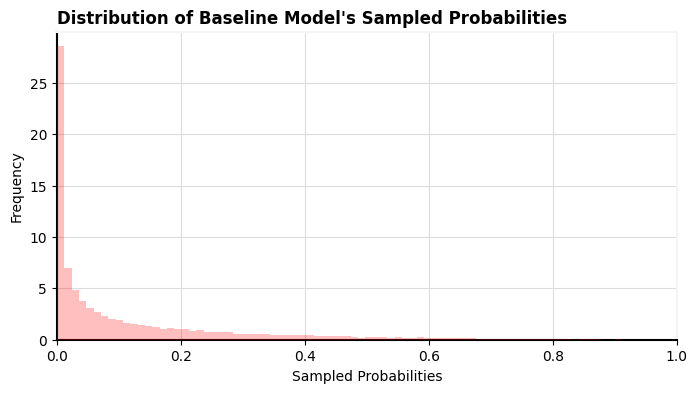

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.hist(
    df_test_preds["pred_proba"],
    density=True,
    bins="auto",
    color="red",
    histtype="stepfilled",
    alpha=0.25,
    label="baseline",
    zorder=10,
)
ax.set_xlim([0, 1])
ax.set_title(
    f"Distribution of Baseline Model's Sampled Probabilities",
    loc="left",
    fontweight="bold",
)
ax.set_xlabel("Sampled Probabilities")
ax.set_ylabel("Frequency")
customize_axis(ax)

::: {.callout-note title="Notes"}

1. There could be other distributions that can be used as a baseline model for the current use-case, but they were not explored in this version of the analysis.
:::

::: {.callout-tip title="Observations"}

1. As expected, the distribution is strongly right skewed with most probabilities being less than 10%. Also the range of sampled values produced by the `beta` distribution covers a range of 0.0 to 1.0. Both of these observations meet the requirements of a suitable baseline model that were discussed earlier.
:::

## Export to Disk

The scores from the baseline model evaluation section above will now be exported to disk so that ML model performance (in the next step) can be compared to the baseline performance found here.

Define datatypes for the `DataFrame` with the overall model evaluation scores

In [45]:
# | code-fold: false
dtypes_dict_scores = {
    "accuracy": pd.Float32Dtype(),
    "balanced_accuracy": pd.Float32Dtype(),
    "precision": pd.Float32Dtype(),
    "recall": pd.Float32Dtype(),
    "f1": pd.Float32Dtype(),
    "f05": pd.Float32Dtype(),
    "f2": pd.Float32Dtype(),
    "brier": pd.Float32Dtype(),
    "pr_auc": pd.Float32Dtype(),
    "uplift": pd.Float32Dtype(),
    "model_type": pd.StringDtype(),
    "params": pd.StringDtype(),
    "true_class_imbalance": pd.Float32Dtype(),
    "pred_class_imbalance": pd.Float32Dtype(),
    "pct_chg_class_imbalance": pd.Float32Dtype(),
}

Define datatypes for the `DataFrame` with the model evaluation scores by sub-category

In [46]:
# | code-fold: false
dtypes_dict_scores_by_sub_category = {
    "accuracy": pd.Float32Dtype(),
    "balanced_accuracy": pd.Float32Dtype(),
    "precision": pd.Float32Dtype(),
    "recall": pd.Float32Dtype(),
    "f1": pd.Float32Dtype(),
    "f05": pd.Float32Dtype(),
    "f2": pd.Float32Dtype(),
    "brier": pd.Float32Dtype(),
    "pr_auc": pd.Float32Dtype(),
    "uplift": pd.Float32Dtype(),
    "model_type": pd.StringDtype(),
    "feature": pd.StringDtype(),
    "sub_category": pd.StringDtype(),
    "observations_by_subcat": pd.Int16Dtype(),
    "observations_by_cat": pd.StringDtype(),
    "true_class_imbalance": pd.Float32Dtype(),
    "pred_class_imbalance": pd.Float32Dtype(),
    "pct_chg_class_imbalance": pd.Float32Dtype(),
    "rank_uplift": pd.Int8Dtype(),
    "rank_uplift_by_feature": pd.Int8Dtype(),
}

Define datatypes for the `DataFrame` with the model predictions for all observations in the test split

In [47]:
# | code-fold: false
dtypes_dict_predictions = {
    "true": pd.Int8Dtype(),
    "bounces": pd.Int8Dtype(),
    "last_action": pd.Int8Dtype(),
}

Export overall evaluation scores

In [48]:
# | code-fold: false
(
    df_evaluation_scores[["name", "value_test"]]
    .set_index("name")
    .transpose()
    .astype(dtypes_dict_scores)
    .to_parquet(
        os.path.join(models_dir, "baseline_scores_overall_test.parquet.gzip"),
        index=False,
        engine="pyarrow",
        compression="gzip",
    )
)

Export evaluation scores by sub-category for the popular sub-categories in the categorical features

In [49]:
# | code-fold: false
(
    df_scores_eval_sub_cats.astype(dtypes_dict_scores_by_sub_category).to_parquet(
        os.path.join(models_dir, "baseline_scores_by_sub_category_test.parquet.gzip"),
        index=False,
        engine="pyarrow",
        compression="gzip",
    )
)

Export predicted probabilities for the test split

In [50]:
# | code-fold: false
(
    df_test_preds.astype(dtypes_dict_predictions).to_parquet(
        os.path.join(models_dir, "predictions_test.parquet.gzip"),
        index=False,
        engine="pyarrow",
        compression="gzip",
    )
)

## Summary of Tasks Performed

This step trained a baseline model to predict visitor propensity to make a purchase during their next visit during January 2017.

The steps performed were
1. choose an appropriate baseline model to model prediction probabilities (predicted visitor propensities)
   - the `beta` distribution was chosen since [it randomly samples values between 0 and 1](https://www.sciencedirect.com/topics/mathematics/beta-distribution), which is required for the current use-case
2. model validation
   - optimize hyperparameters of the baseline model
   - uses validation data split
   - determines best hyperparameters
3. model evaluation
   - uses model with best hyperparameters to make predictions on data that has not been seen during ML model development
   - uses test data split
   - post-processing
     - assesses model's performance across the most popular sub-categories in all categorical features in the transformed data from the test data split

## Key Findings

1. The baseline model cannot generalize since it does not use features. It cannot handle changes in class imbalance seen between model validation and model evaluation.
   - input features will likely be key to improving on this performance using a ML model
2. Several evaluation metrics are more sentitive to changes in sub-category than to changes in baseline model hyperparameters
   - model performance should be compared to ML model performance for each of the popular sub-categories
   - this further re-inforces the finding from 1. above

## Summary of Assumptions

1. It is assumed that the class imbalance can be adequately represented by the `beta` distribution. The parameters of this distribution are modified during model validation in order to capture the class-imbalance seen in the validation data split.
2. The top three sub-categories are considered for evaluating baseline model performance since these occurred in at least 10% of all observations (visits) per category.

## Limitations

1. A single choice of skewed distribution (`beta`) was used to represent the baseline model. This was chosen since it can sample values in the range of 0 to 1, which is the range of prediction probabilities that we want for a binary classification model.
2. For the `uplift` evaluation metric, ventiles (20 bins) were used. However, other binning approaches (deciles, which would give 10 bins) were not explored.
3. The definition of `uplift` does not make a comparison of the predicted and true class labels. Instead, it only defines ventiles based on the predicted probability. This is acceptable since uplift is meant to compare a model's predictive power to a random model. However, this also means it is possible to have a non-zero uplift with an inaccurate model. For this reason, the other metric (area under the precision-recall curve) must also be used to evaluate model performance, in addition to `uplift`.
4. The baseline model does not learn from features so its hyperparameters were only chosen based on its ability to match the class imbalance seen in the validation data split. This does not generalize to unseen data with a different class imbalance, but this is adequate for a baseline model.

## Next Step

The next step in the analysis will repeat the analysis in this step, but with a machine learning model used in place of the baseline visitor propensity (binary classifier) model used here. A ML model that is able to deliver value to the business user for this project should outperform the evaluation scores reported here for the baseline model.

Since the end-to-end ML development workflow is very similar to the workflow shown here, comments will only be included in that step for new steps, such as feature engineering, feature transformation, etc., that were not necessary for a baseline model.